In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import Date, cast, func, select
from sqlalchemy.orm import sessionmaker

from shipping_cost_analysis.etl import preprocessing
from shipping_cost_analysis.etl.db_tools import get_engine
from shipping_cost_analysis.models.schema import Customer, Product, Region, Transactions

pd.set_option("display.max_columns", None)

In [2]:
engine = get_engine()
Session = sessionmaker(bind=engine)

with engine.connect() as conn:
    query = (
        select(
            cast(Transactions.transaction_date, Date),
            Transactions.customer_id,
            Transactions.stock_code,
            Transactions.invoice_no,
            Transactions.quantity,
            Transactions.unit_price,
            Transactions.sales,
            Customer.order_postal,
            Customer.order_city,
            Customer.order_state,
            Customer.latitude,
            Customer.longitude,
            Product.landed_cost,
            Product.shipping_cost_1000_r,
            Product.weight,
            Product.category,
            Product.description,
            Region.state,
            Region.region,
        )
        .join(Transactions, Transactions.stock_code == Product.stock_code)
        .join(Customer, Transactions.customer_id == Customer.customer_id)
        .join(Region, Region.order_state == Customer.order_state)
    )

    df = pd.read_sql(query, conn)

In [3]:
display(df.shape)
df.head()

(19555, 19)

,transaction_date,customer_id,stock_code,invoice_no,quantity,unit_price,sales,order_postal,order_city,order_state,latitude,longitude,landed_cost,shipping_cost_1000_r,weight,category,description,state,region
0,2020-12-01,17850,85123A,536365.0,1,15.30,15.30,22473,Heathsville,VA,37.9176,-76.4722,6.0,5.0,2.0,Disposables,Dog and Puppy Pads,Virginia,East
1,2020-12-01,13047,84879,536367.0,6,10.14,60.84,92869,Orange,CA,33.7873,-117.8503,4.0,4.0,1.0,Cleanig Supplies,Pet Odor Eliminator,California,West
2,2020-12-01,17850,85123A,536373.0,1,15.30,15.30,22473,Heathsville,VA,37.9176,-76.4722,6.0,5.0,2.0,Disposables,Dog and Puppy Pads,Virginia,East
3,2020-12-01,15291,22114,536376.0,8,20.70,165.60,48127,Dearborn Heights,MI,42.3370,-83.2733,8.0,5.0,0.5,Grooming,ChomChom Pet Hair Remover - Reusable Cat and D...,Michigan,Central
4,2020-12-01,17850,85123A,536375.0,1,15.30,15.30,22473,Heathsville,VA,37.9176,-76.4722,6.0,5.0,2.0,Disposables,Dog and Puppy Pads,Virginia,East


**Preprocessing**

In [6]:
preprocessing.missing_data(df)

,Total,Percentage Missing


In [5]:
df = df.dropna()

In [10]:
df.groupby(["category"])["description"].nunique()

category
Cleanig Supplies    1
Disposables         4
Electronics         2
Food                6
Grooming            4
Pet Food            1
Supplements         2
Name: description, dtype: int64

In [11]:
df.category = df.category.replace(
    {"Cleanig Supplies": "Disposables", "Pet Food": "Food"}
)

In [12]:
df.groupby(["category"])["description"].nunique()

category
Disposables    5
Electronics    2
Food           7
Grooming       4
Supplements    2
Name: description, dtype: int64

In [7]:
# check different unit price per stock code

df.groupby("stock_code")["unit_price"].unique()

stock_code
20725                                     [9.9, 8.7, 24.78]
21137                                  [20.34, 22.5, 44.76]
22086                                   [17.7, 15.3, 34.74]
22114           [20.7, 23.7, 25.5, 22.5, 27.9, 49.74, 30.6]
22197                                     [4.32, 5.1, 9.78]
22386         [11.7, 9.9, 12.48, 10.44, 10.74, 10.5, 24.78]
22423                      [65.7, 76.5, 30.0, 24.0, 149.76]
22502                                    [35.7, 29.7, 12.0]
22720              [29.7, 25.5, 30.48, 31.08, 20.34, 64.74]
22960                      [22.5, 25.5, 17.76, 27.6, 49.74]
23084                          [12.48, 10.74, 24.78, 10.02]
23203                       [12.48, 11.7, 9.9, 10.74, 10.5]
23284         [47.7, 40.5, 27.48, 49.5, 42.48, 48.0, 99.78]
23298                                   [29.7, 24.9, 30.84]
47566                 [27.9, 22.5, 29.7, 24.9, 25.8, 64.74]
79321     [22.92, 29.7, 25.5, 23.88, 34.5, 27.9, 74.76, ...
82484     [38.7, 33.3, 28.68,

### **Explore distributions & relationships**

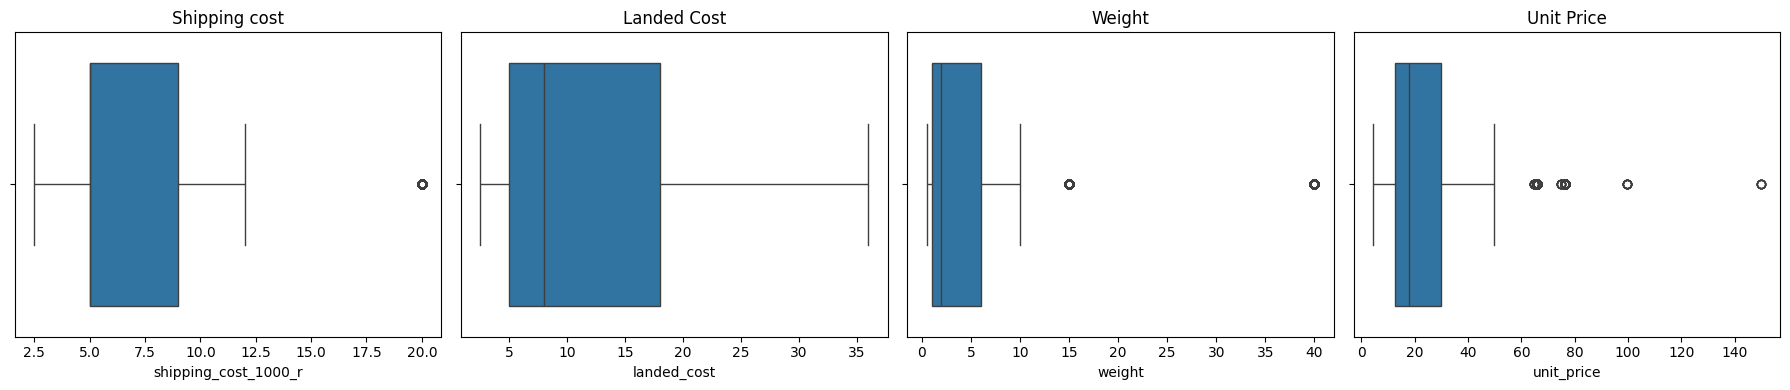

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

sns.boxplot(data=df, x="shipping_cost_1000_r", ax=axs[0])
axs[0].set_title("Shipping cost")

sns.boxplot(data=df, x="landed_cost", ax=axs[1])
axs[1].set_title("Landed Cost")

sns.boxplot(data=df, x="weight", ax=axs[2])
axs[2].set_title("Weight")

sns.boxplot(data=df, x="unit_price", ax=axs[3])
axs[3].set_title("Unit Price")

plt.tight_layout()
plt.show()

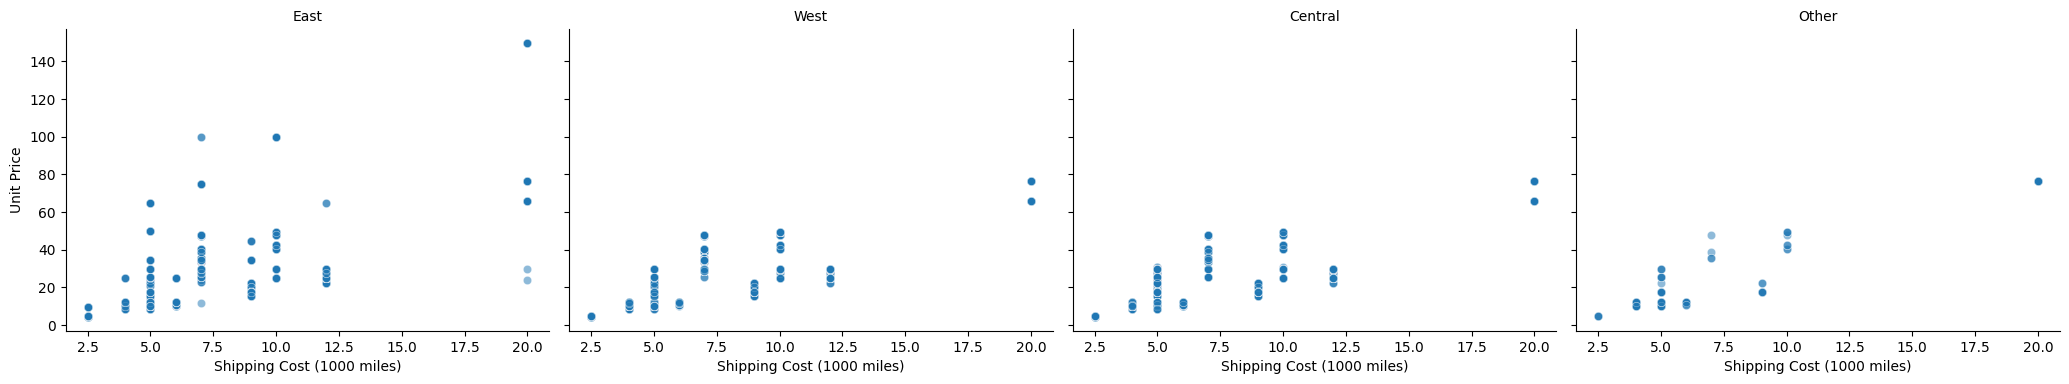

In [14]:
g = sns.FacetGrid(
    df,
    col="region",
    col_wrap=4,
    height=4,
    aspect=1.3,  # (width = 4 × 1.2 = 4.8)
    sharex=True,
    sharey=True,
)

g.map_dataframe(sns.scatterplot, x="shipping_cost_1000_r", y="unit_price", alpha=0.5)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Shipping Cost (1000 miles)", "Unit Price")
plt.subplots_adjust(top=0.9)
plt.show()

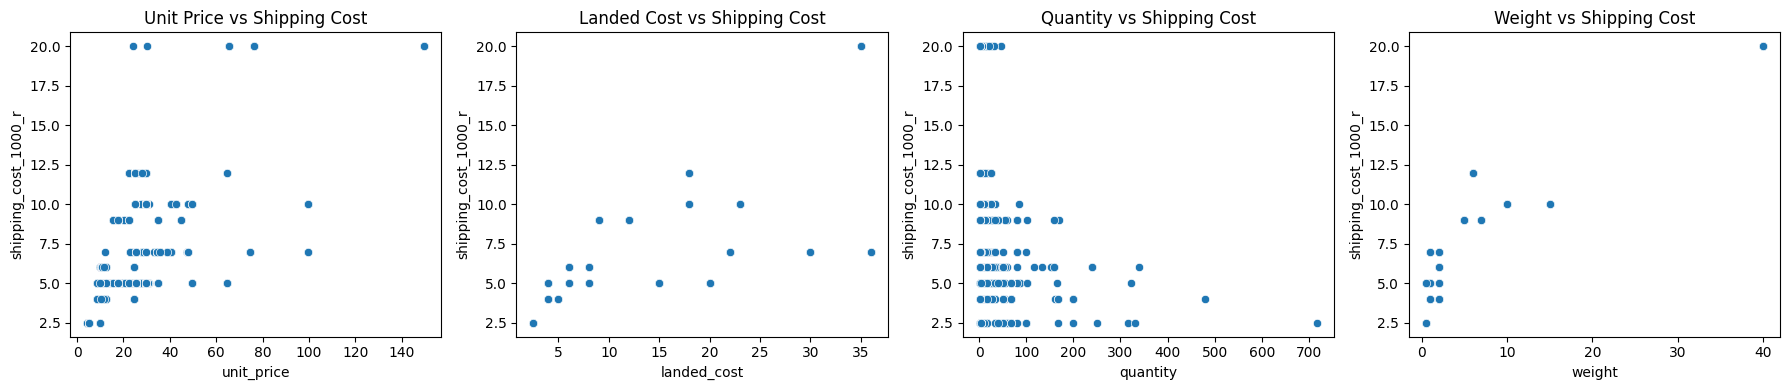

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

sns.scatterplot(data=df, x="unit_price", y="shipping_cost_1000_r", ax=axs[0])
axs[0].set_title("Unit Price vs Shipping Cost")

sns.scatterplot(data=df, x="landed_cost", y="shipping_cost_1000_r", ax=axs[1])
axs[1].set_title("Landed Cost vs Shipping Cost")

sns.scatterplot(data=df, x="quantity", y="shipping_cost_1000_r", ax=axs[2])
axs[2].set_title("Quantity vs Shipping Cost")

sns.scatterplot(data=df, x="weight", y="shipping_cost_1000_r", ax=axs[3])
axs[3].set_title("Weight vs Shipping Cost")

plt.tight_layout()
plt.show()

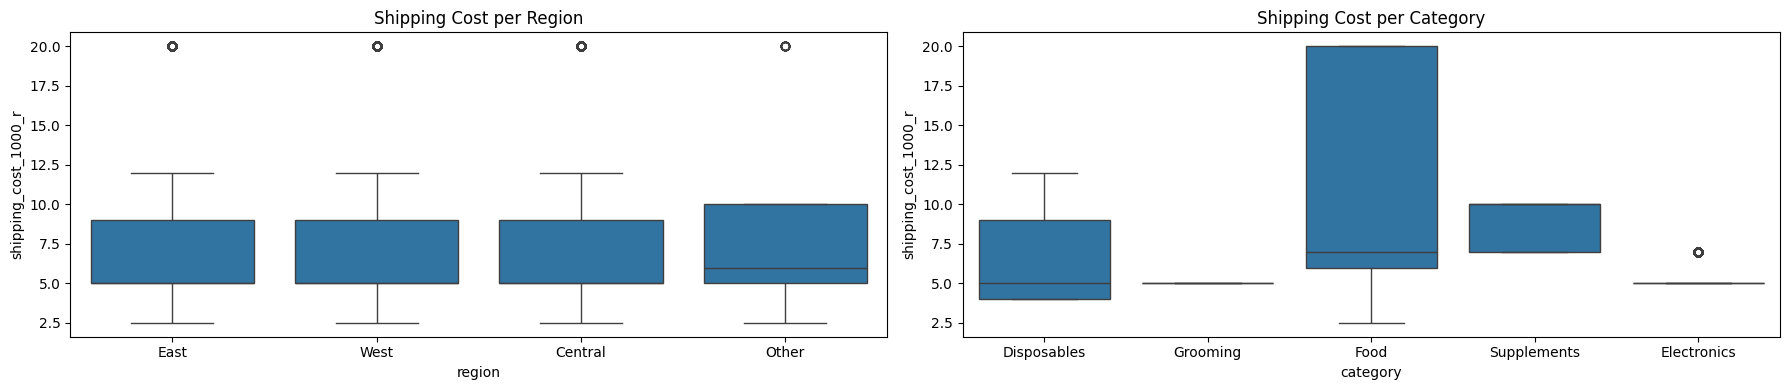

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4))
sns.boxplot(data=df, x="region", y="shipping_cost_1000_r", ax=axs[0])
axs[0].set_title("Shipping Cost per Region")
sns.boxplot(data=df, x="category", y="shipping_cost_1000_r", ax=axs[1])
axs[1].set_title("Shipping Cost per Category")
plt.tight_layout()
plt.show()

### **Calculate KPIs**

In [18]:
# customer LTV
cltv = df.groupby("customer_id").agg(cltv=("sales", "sum")).reset_index()
df = df.merge(cltv, on="customer_id")

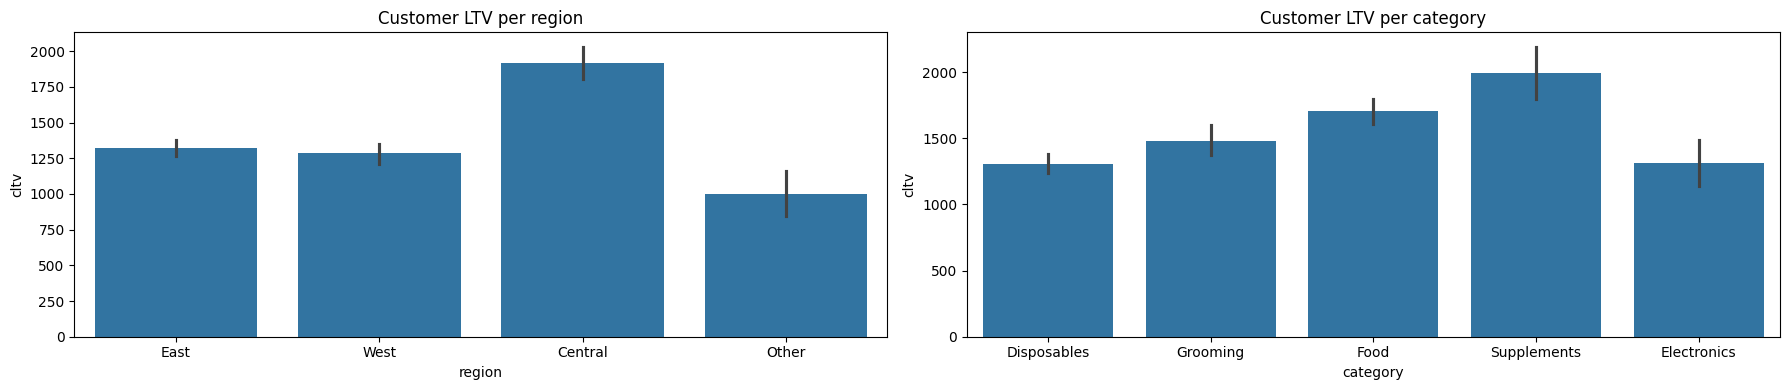

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4))
sns.barplot(data=df, x="region", y="cltv", ax=axs[0])
sns.barplot(data=df, x="category", y="cltv", ax=axs[1])
axs[0].set_title("Customer LTV per region")
axs[1].set_title("Customer LTV per category")
plt.tight_layout()
plt.show()

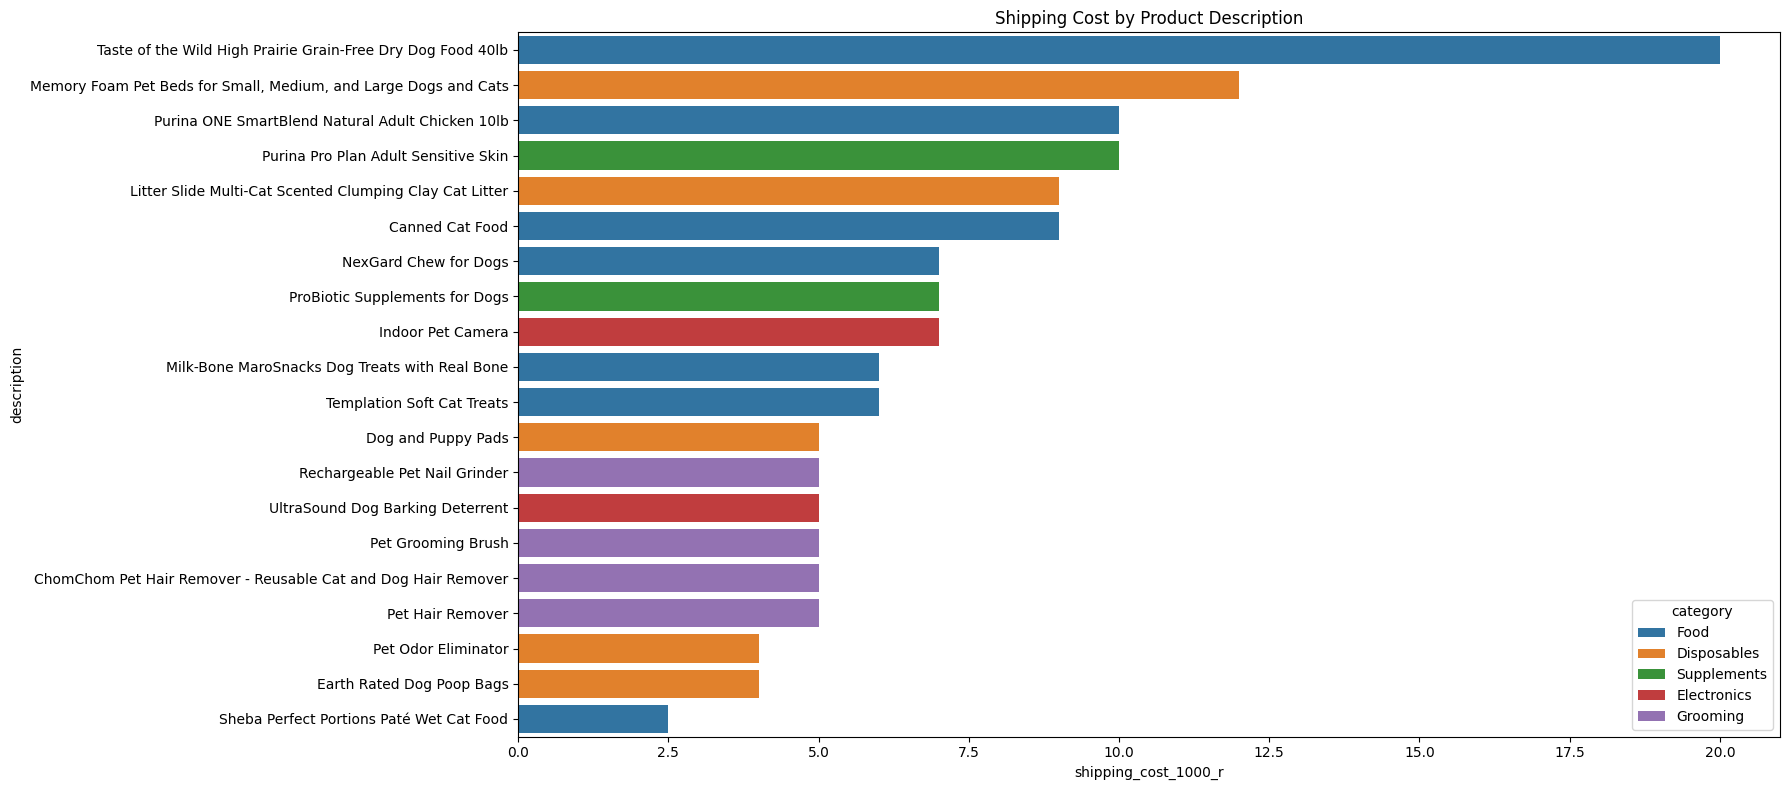

In [26]:
df_sorted = df.sort_values("shipping_cost_1000_r", ascending=False)

df_sorted["description"] = pd.Categorical(
    df_sorted["description"], categories=df_sorted["description"].unique(), ordered=True
)

# Plot
fig, axs = plt.subplots(1, 1, figsize=(18, 8))
sns.barplot(
    data=df_sorted, y="description", x="shipping_cost_1000_r", hue="category", ax=axs
)
axs.set_title("Shipping Cost by Product Description")
plt.tight_layout()
plt.show()

In [20]:
# Cost of Goods Sold (COGS)
df["cogs"] = df["landed_cost"] * df["quantity"]

In [21]:
# actual shipping cost per transaction
df["shipping_cost_real"] = df["shipping_cost_1000_r"] * df["quantity"]

In [22]:
# Profit
df["profit_baseline"] = df["sales"] - df["cogs"] - df["shipping_cost_real"]
df["profit_margin"] = df["profit_baseline"] / df["sales"].replace(0, np.nan)

In [23]:
# caculate some ratios
df["shipping_cost_per_sale"] = df["shipping_cost_real"] / df["sales"].replace(0, np.nan)
df["shipping_cost_per_unit"] = df["shipping_cost_real"] / df["quantity"].replace(
    0, np.nan
)
df["shipping_cost_per_unit"] = df["shipping_cost_real"] / df["quantity"].replace(
    0, np.nan
)
df["cogs_per_unit"] = df["cogs"] / df["quantity"].replace(0, np.nan)
df["gross_profit_per_unit"] = (
    df["unit_price"] - df["landed_cost"] - df["shipping_cost_1000_r"]
)
df["shipping_cost_vs_cogs"] = df["shipping_cost_real"] / df["cogs"].replace(0, np.nan)

In [29]:
metrics = [
    "category",
    "quantity",
    "unit_price",
    "sales",
    "weight",
    "cltv",
    "cogs",
    "landed_cost",
    "shipping_cost_1000_r",
    "shipping_cost_real",
    "profit_baseline",
    "profit_margin",
    "shipping_cost_per_sale",
    "shipping_cost_per_unit",
    "cogs_per_unit",
    "gross_profit_per_unit",
    "shipping_cost_vs_cogs",
]


def highlight_min_max(row):
    is_max = row == row.max()
    is_min = row == row.min()

    return [
        (
            "background-color: lightblue"
            if max_
            else "background-color: lightpink" if min_ else ""
        )
        for max_, min_ in zip(is_max, is_min)
    ]


(
    df[metrics]
    .groupby("category")
    .mean()
    .round(2)
    .T.style.apply(highlight_min_max, axis=1)
    .format("{:.2f}")
    .set_properties(**{"font-size": "12px", "padding": "3px"})
    .set_table_styles(
        [
            {"selector": "th", "props": [("min-width", "80px")]},
            {"selector": "td", "props": [("min-width", "80px")]},
        ]
    )
)

category,Disposables,Electronics,Food,Grooming,Supplements
quantity,3.76,1.57,3.87,2.56,2.58
unit_price,17.01,30.56,34.13,16.17,40.74
sales,54.33,46.36,75.38,35.36,89.57
weight,3.21,1.00,13.37,0.76,8.69
cltv,1308.48,1313.05,1703.59,1481.75,1989.38
cogs,25.99,35.22,43.08,17.28,57.83
landed_cost,8.00,22.60,17.97,7.66,22.55
shipping_cost_1000_r,6.41,5.32,10.06,5.00,8.65
shipping_cost_real,21.36,8.33,27.44,12.80,21.08
profit_baseline,6.98,2.82,4.86,5.28,10.65


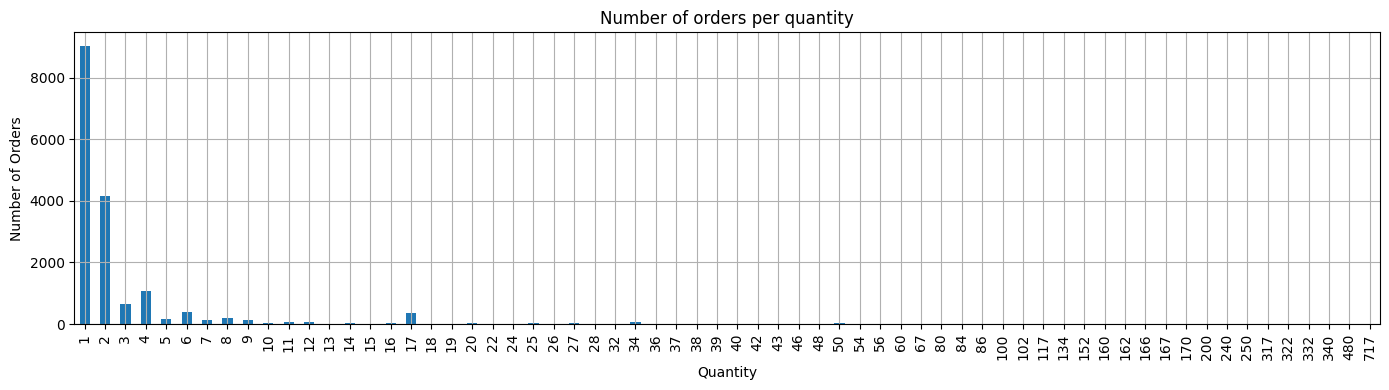

In [55]:
df.groupby("quantity").size().plot(
    kind="bar", figsize=(14, 4), title="Number of orders per quantity"
)
plt.xlabel("Quantity")
plt.ylabel("Number of Orders")
plt.grid(True)
plt.tight_layout()
plt.show()

### **Calculate baseline & hypothesis**

In [30]:
def calc_baseline_shipping(cost_per_unit, quantity):
    if pd.isna(quantity) or quantity <= 0:
        return 0
    # Geometrische Reihe: Sum of 0.7^i for i in range(quantity)
    weights = sum(0.7**i for i in range(int(quantity)))
    return cost_per_unit * weights


df["shipping_cost_baseline"] = df.apply(
    lambda row: calc_baseline_shipping(row["shipping_cost_1000_r"], row["quantity"]),
    axis=1,
)

In [31]:
def hypothesis_factor(q):
    if q <= 1:
        return 1.0
    elif q <= 2:
        return 0.8
    elif q <= 4:
        return 0.6
    elif q <= 7:
        return 0.5
    elif q <= 9:
        return 0.4
    else:
        return 0.3


df["hypothesis_factor"] = df["quantity"].apply(hypothesis_factor)
df["shipping_cost_hypothesis"] = (
    df["shipping_cost_1000_r"] * df["quantity"] * df["hypothesis_factor"]
)

In [33]:
df["saving_baseline_vs_real"] = df["shipping_cost_real"] - df["shipping_cost_baseline"]
df["saving_hypothesis_vs_real"] = (
    df["shipping_cost_real"] - df["shipping_cost_hypothesis"]
)

In [43]:
# make costs comparable

df["unit_cost_real"] = df["shipping_cost_real"] / df["quantity"]
df["unit_cost_baseline"] = df["shipping_cost_baseline"] / df["quantity"]
df["unit_cost_hypothesis"] = df["shipping_cost_hypothesis"] / df["quantity"] 

df["unit_saving_baseline"] = df["unit_cost_real"] - df["unit_cost_baseline"]
df["unit_saving_hypothesis"] = df["unit_cost_real"] - df["unit_cost_hypothesis"]

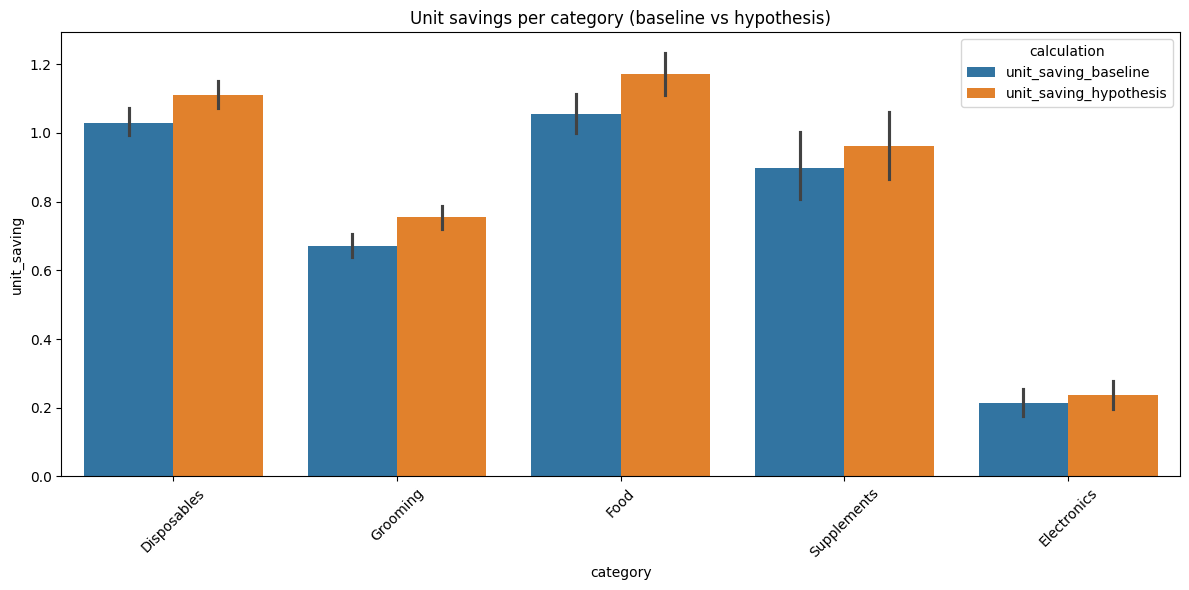

In [54]:
df_long = df.melt(
    id_vars="category",
    value_vars=["unit_saving_baseline", "unit_saving_hypothesis"],
    var_name="calculation",
    value_name="unit_saving"
)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_long, x="category", y="unit_saving", hue="calculation")
plt.title("Unit savings per category (baseline vs hypothesis)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

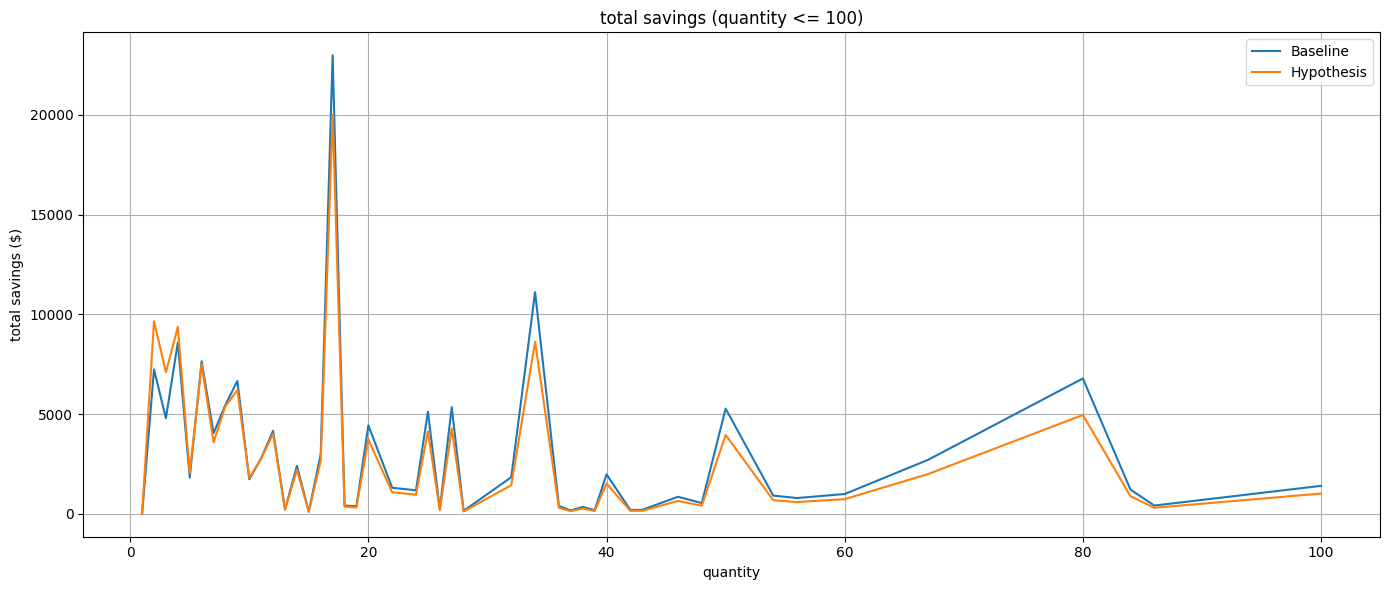

In [46]:
df_sub_grouped = (
    df[df.quantity <= 100]
    .groupby("quantity")[["saving_baseline_vs_real", "saving_hypothesis_vs_real"]]
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=df_sub_grouped, x="quantity", y="saving_baseline_vs_real", label="Baseline"
)
sns.lineplot(
    data=df_sub_grouped, x="quantity", y="saving_hypothesis_vs_real", label="Hypothesis"
)
plt.title("total savings (quantity <= 100)")
plt.ylabel("total savings ($)")
plt.xlabel("quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

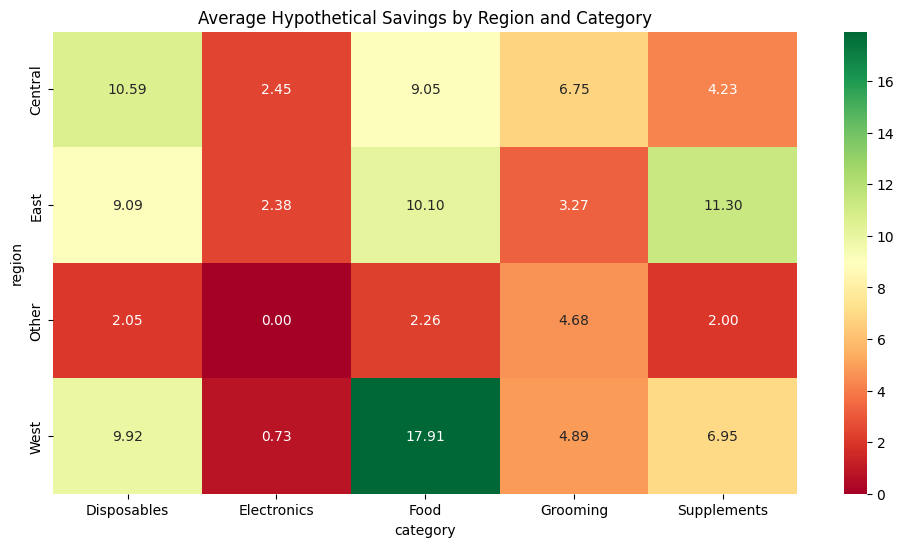

In [37]:
pivot = df.pivot_table(
    values="saving_hypothesis_vs_real",
    index="region",
    columns="category",
    aggfunc="mean",
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdYlGn")
plt.title("Average Hypothetical Savings by Region and Category")
plt.show()

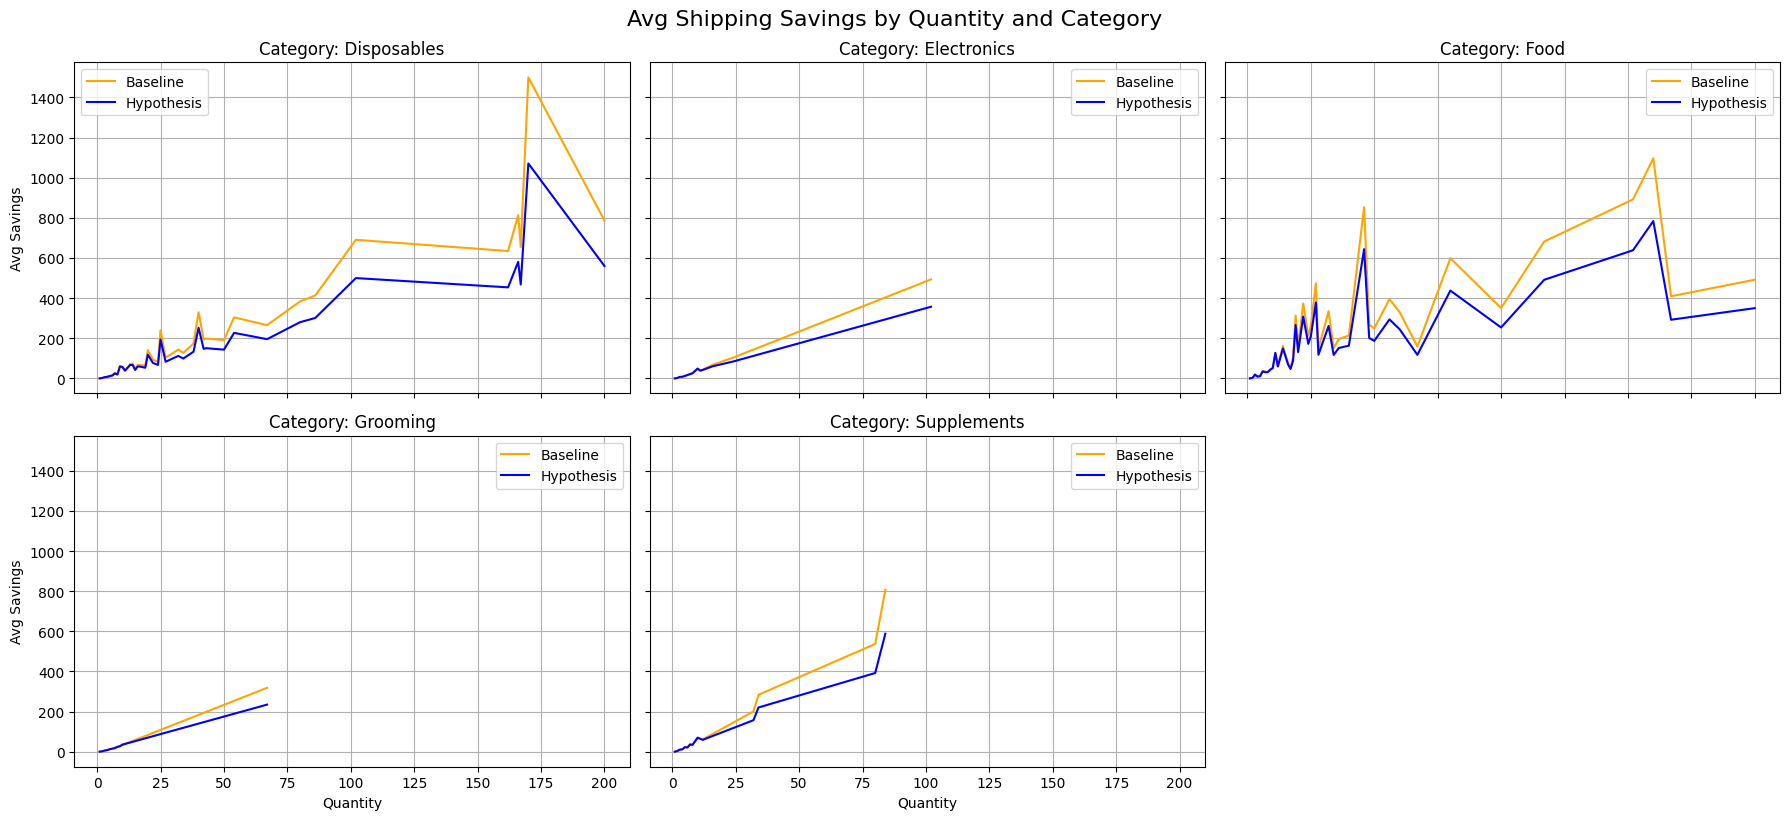

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Begrenzung auf sinnvolle Mengen
df_sub = df[df["quantity"] <= 200]

# Gruppieren: nach category UND quantity
grouped = (
    df_sub.groupby(["category", "quantity"])[
        ["saving_baseline_vs_real", "saving_hypothesis_vs_real"]
    ]
    .mean()
    .reset_index()
)

# Alle Kategorien
categories = grouped["category"].unique()
n = len(categories)

# Grid: z. B. 2 Zeilen, 3 Spalten
rows = 2
cols = (n + 1) // 2  # Automatisch passende Spaltenzahl

fig, axs = plt.subplots(rows, cols, figsize=(18, 8), sharex=True, sharey=True)
axs = axs.flatten()

# Plot pro Kategorie
for i, cat in enumerate(categories):
    ax = axs[i]
    df_cat = grouped[grouped["category"] == cat]

    sns.lineplot(
        data=df_cat,
        x="quantity",
        y="saving_baseline_vs_real",
        ax=ax,
        label="Baseline",
        color="orange",
    )
    sns.lineplot(
        data=df_cat,
        x="quantity",
        y="saving_hypothesis_vs_real",
        ax=ax,
        label="Hypothesis",
        color="blue",
    )

    ax.set_title(f"Category: {cat}")
    ax.set_xlabel("Quantity")
    ax.set_ylabel("Avg Savings")
    ax.grid(True)
    ax.legend()

# Leere Plots ausblenden, falls weniger Kategorien als Subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle("Avg Shipping Savings by Quantity and Category", fontsize=16, y=1.02)
plt.show()

**Export data for analysis in Tableau**

In [40]:
df.to_excel("../data/ecommerce_shipping_data.xlsx", index=False)